In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")

In [5]:
btc_price = pd.read_csv(
    "../data/raw/btc_prices.csv",
    parse_dates = ["date"]
)

nifty_price = pd.read_csv(
    "../data/raw/nifty_prices.csv",
    parse_dates = ["date"]
)

sent = pd.read_csv(
    "../data/processed/text_with_sentiment.csv",
    parse_dates = ["timestamp"]
)

In [6]:
btc_price["date"] = pd.to_datetime(btc_price["date"]).dt.tz_localize(None)
nifty_price["date"] = pd.to_datetime(nifty_price["date"]).dt.tz_localize(None)

sent["date"] = sent["timestamp"].dt.tz_localize(None).dt.date
sent["date"] = pd.to_datetime(sent["date"])

In [7]:
btc_daily_sent = (
    sent[sent["asset"] == "BTC"]
    .groupby("date", as_index=False)
    .agg(sentiment=("finbert_score", "mean"))
)

nifty_daily_sent = (
    sent[sent["asset"] == "NIFTY"]
    .groupby("date", as_index=False)
    .agg(sentiment=("finbert_score", "mean"))
)

In [8]:
btc_plot_df = pd.merge(
    btc_price[["date", "close"]],
    btc_daily_sent,
    on="date",
    how="inner"
).rename(columns={"close": "close_price"})

nifty_plot_df = pd.merge(
    nifty_price[["date", "close"]],
    nifty_daily_sent,
    on="date",
    how="inner"
).rename(columns={"close": "close_price"})

In [9]:
for df in [btc_plot_df, nifty_plot_df]:
    df.sort_values("date", inplace=True)

    df["price_smooth"] = df["close_price"].rolling(7, min_periods=1).mean()
    df["sentiment_smooth"] = df["sentiment"].rolling(7, min_periods=1).mean()

In [10]:
print(
    btc_plot_df["date"].min(),
    btc_plot_df["date"].max(),
    btc_plot_df["date"].nunique()
)

2024-10-03 00:00:00 2025-01-01 00:00:00 82


In [11]:
import plotly.graph_objects as go

def plot_price_sentiment_daily(df, title):
    fig = go.Figure()

    # PRICE (left axis)
    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["price_smooth"],
        name="Price",
        line=dict(color="#2ecc71", width=2),
        fill="tozeroy",
        yaxis="y1"
    ))

    # SENTIMENT (right axis)
    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sentiment_smooth"],
        name="Sentiment",
        line=dict(color="#F54927", width=2, dash="dash"),
        yaxis="y2"
    ))

    fig.update_layout(
        title=title,
        template="plotly_white",
        hovermode="x unified",
        xaxis=dict(title="Date"),
        yaxis=dict(
            title="Price",
            side="left",
            showgrid=False
        ),
        yaxis2=dict(
            title="Sentiment",
            overlaying="y",
            side="right",
            showgrid=False
        ),
        legend=dict(
            orientation="h",
            y=1.1,
            x=0.5,
            xanchor="center"
        )
    )

    fig.show()


In [12]:
plot_price_sentiment_daily(
    btc_plot_df,
    title="Bitcoin — Daily Price vs Public Sentiment"
)

plot_price_sentiment_daily(
    nifty_plot_df,
    title="NIFTY 50 — Daily Price vs Public Sentiment"
)

In [13]:
btc = pd.read_csv("../data/processed/btc_sentiment_aligned.csv", parse_dates=["date"])
nifty = pd.read_csv("../data/processed/nifty_sentiment_aligned.csv", parse_dates=["date"])

btc = btc.sort_values("date").reset_index(drop=True)
nifty = nifty.sort_values("date").reset_index(drop=True)

In [14]:
def add_volatility(df, window=5):
    df = df.copy()
    df["volatility"] = df["return"].rolling(window).std()
    return df.dropna()

btc = add_volatility(btc)
nifty = add_volatility(nifty)

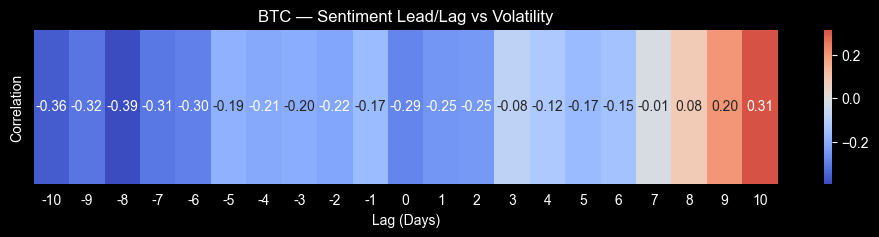

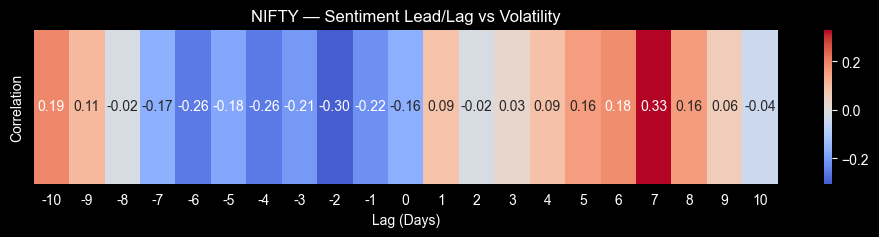

In [15]:
def lead_lag_heatmap(df, asset):
    lags = range(-10, 11)
    corr_vals = []

    for lag in lags:
        shifted_sent = df["finbert_score"].shift(lag)
        corr = shifted_sent.corr(df["volatility"])
        corr_vals.append(corr)

    heatmap_df = pd.DataFrame(
        {"Lag (Days)": lags, "Correlation": corr_vals}
    ).set_index("Lag (Days)")

    plt.figure(figsize=(12, 2))
    sns.heatmap(
        heatmap_df.T,
        cmap="coolwarm",
        center=0,
        annot=True,
        fmt=".2f"
    )
    plt.title(f"{asset} — Sentiment Lead/Lag vs Volatility")
    plt.show()

lead_lag_heatmap(btc, "BTC")
lead_lag_heatmap(nifty, "NIFTY")

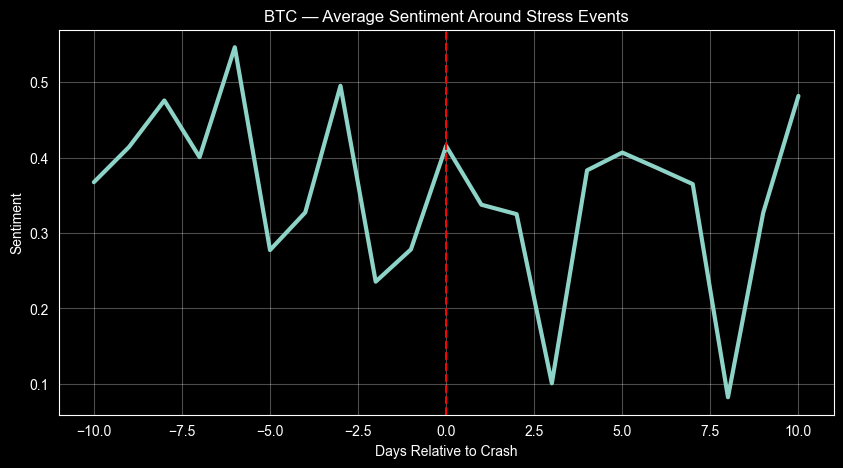

[WARN] Not enough stress events for NIFTY


In [22]:
def stress_event_alignment(
    df,
    asset,
    sentiment_col="finbert_score",
    return_col="return",
    threshold=-0.02,
    window=10
):
    df = df.reset_index(drop=True).copy()

    if sentiment_col not in df.columns:
        raise ValueError(f"{sentiment_col} not found in dataframe")

    # Identify crash days
    df["crash"] = df[return_col] < threshold
    crash_days = df[df["crash"]].index.tolist()

    if len(crash_days) < 3:
        print(f"[WARN] Not enough stress events for {asset}")
        return

    sent_windows = []

    for idx in crash_days:
        start = idx - window
        end = idx + window

        if start < 0 or end >= len(df):
            continue

        sent_windows.append(
            df.loc[start:end, sentiment_col].values
        )

    if len(sent_windows) == 0:
        print(f"[WARN] No valid windows for {asset}")
        return

    avg_sent = np.mean(sent_windows, axis=0)

    x = range(-window, window + 1)

    plt.figure(figsize=(10,5))
    plt.plot(x, avg_sent, linewidth=3)
    plt.axvline(0, color="red", linestyle="--")
    plt.title(f"{asset} — Average Sentiment Around Stress Events")
    plt.xlabel("Days Relative to Crash")
    plt.ylabel("Sentiment")
    plt.grid(alpha=0.3)
    plt.show()

stress_event_alignment(btc, "BTC")
stress_event_alignment(nifty, "NIFTY")

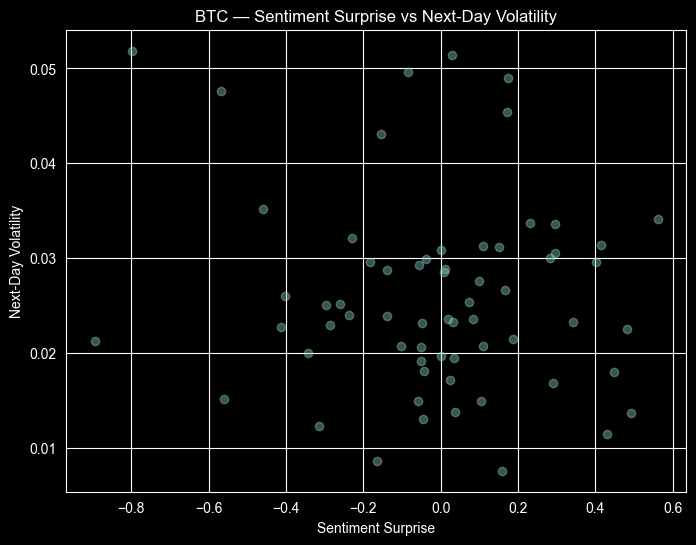

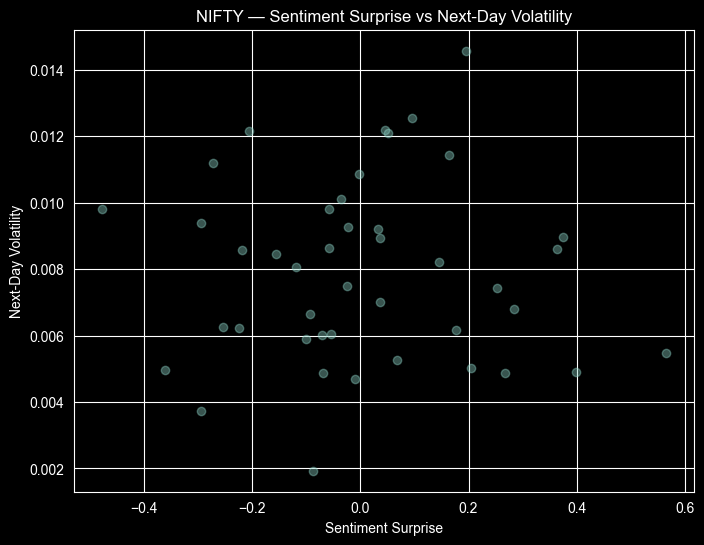

In [17]:
def sentiment_surprise_plot(df, asset):
    df = df.copy()
    df["sentiment_surprise"] = (
        df["finbert_score"] - df["finbert_score"].rolling(7).mean()
    )
    df["next_vol"] = df["volatility"].shift(-1)
    df = df.dropna()

    plt.figure(figsize=(8,6))
    plt.scatter(
        df["sentiment_surprise"],
        df["next_vol"],
        alpha=0.4
    )
    plt.title(f"{asset} — Sentiment Surprise vs Next-Day Volatility")
    plt.xlabel("Sentiment Surprise")
    plt.ylabel("Next-Day Volatility")
    plt.show()

sentiment_surprise_plot(btc, "BTC")
sentiment_surprise_plot(nifty, "NIFTY")

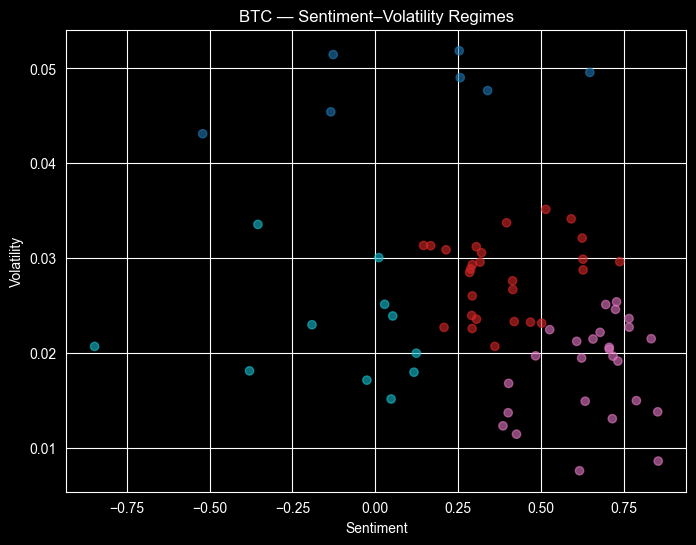

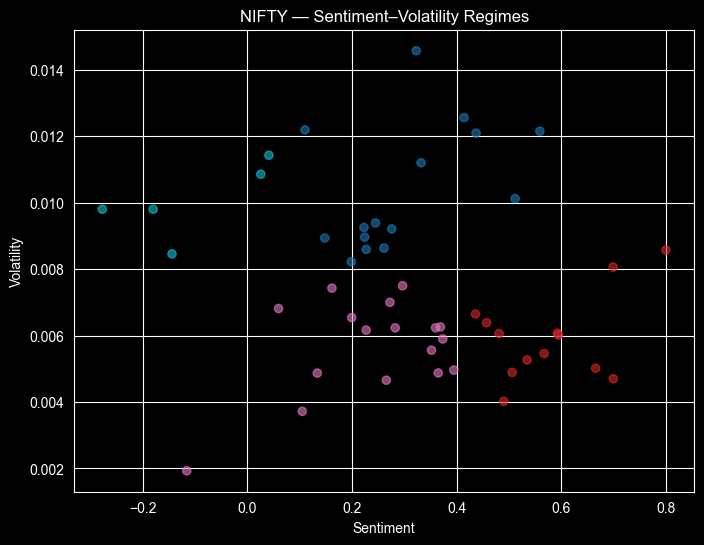

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def regime_map(df, asset):
    X = df[["finbert_score", "volatility"]].dropna()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(
        X["finbert_score"],
        X["volatility"],
        c=clusters,
        cmap="tab10",
        alpha=0.6
    )
    plt.title(f"{asset} — Sentiment–Volatility Regimes")
    plt.xlabel("Sentiment")
    plt.ylabel("Volatility")
    plt.show()

regime_map(btc, "BTC")
regime_map(nifty, "NIFTY")

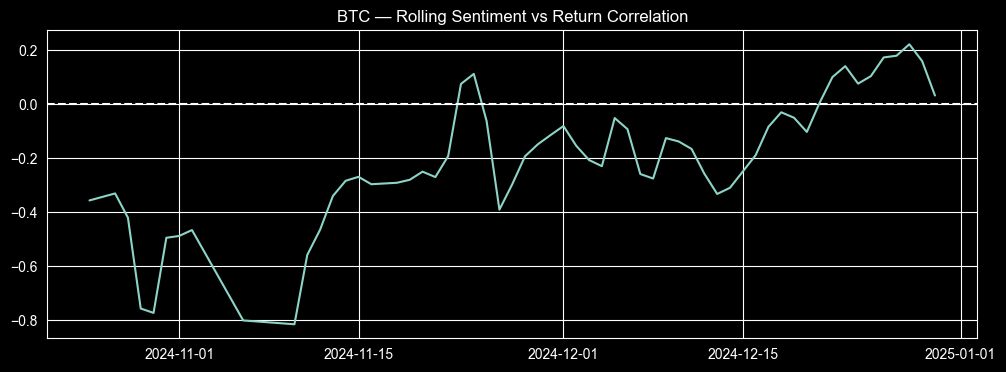

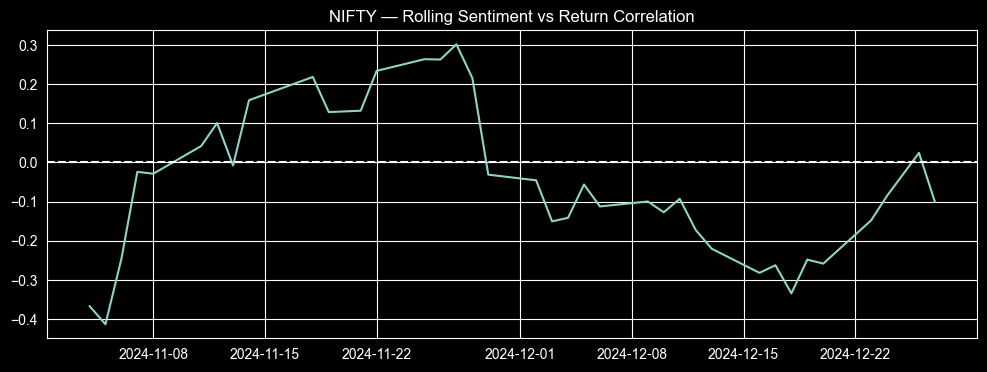

In [19]:
def rolling_corr_plot(df, asset):
    df = df.copy()
    df["rolling_corr"] = (
        df["finbert_score"]
        .rolling(14)
        .corr(df["return"])
    )

    plt.figure(figsize=(12,4))
    plt.plot(df["date"], df["rolling_corr"])
    plt.axhline(0, color="white", linestyle="--")
    plt.title(f"{asset} — Rolling Sentiment vs Return Correlation")
    plt.show()

rolling_corr_plot(btc, "BTC")
rolling_corr_plot(nifty, "NIFTY")

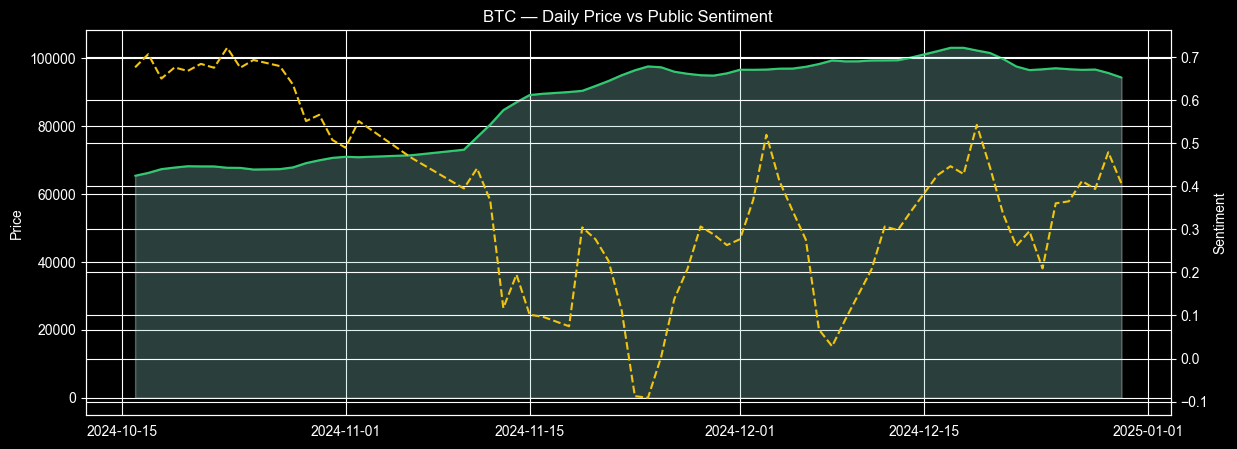

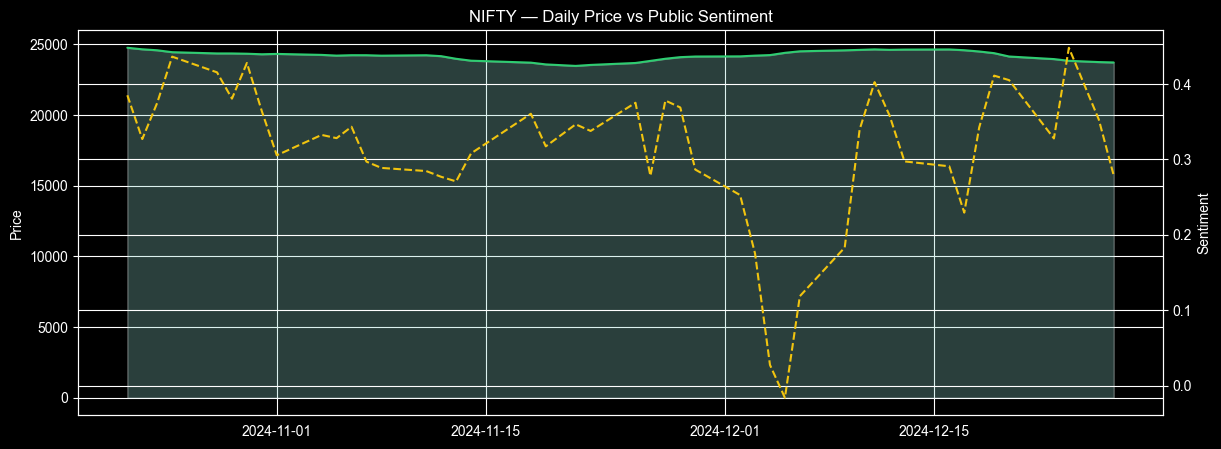

In [20]:
def price_sentiment_overlay(df, asset):
    df = df.copy()
    df["price_smooth"] = df["close"].rolling(5).mean()
    df["sentiment_smooth"] = df["finbert_score"].rolling(5).mean()

    fig, ax1 = plt.subplots(figsize=(14,5))

    ax1.plot(df["date"], df["price_smooth"], color="#2ecc71", label="Price")
    ax1.fill_between(df["date"], df["price_smooth"], alpha=0.3)
    ax1.set_ylabel("Price")

    ax2 = ax1.twinx()
    ax2.plot(
        df["date"],
        df["sentiment_smooth"],
        color="#f1c40f",
        linestyle="--",
        label="Sentiment"
    )
    ax2.set_ylabel("Sentiment")

    plt.title(f"{asset} — Daily Price vs Public Sentiment")
    plt.show()

price_sentiment_overlay(btc, "BTC")
price_sentiment_overlay(nifty, "NIFTY")

In [24]:
print(btc.columns.tolist())

['date', 'close', 'volume', 'return', 'asset', 'finbert_score', 'vader_score', 'finbert_lag_1', 'vader_lag_1', 'finbert_lag_2', 'vader_lag_2', 'finbert_lag_3', 'vader_lag_3', 'finbert_lag_5', 'vader_lag_5', 'volatility']


In [26]:
def add_slopes(df, price_col = "close", sentiment_col = "finbert_score"):
    df = df.sort_values("date").copy()

    if sentiment_col not in df.columns:
        raise ValueError(f"{sentiment_col} not found")

    df["price_slope"] = df[price_col].pct_change()
    df["sentiment_slope"] = df[sentiment_col].diff()

    return df.dropna()

btc_slope = add_slopes(btc)
nifty_slope = add_slopes(nifty)

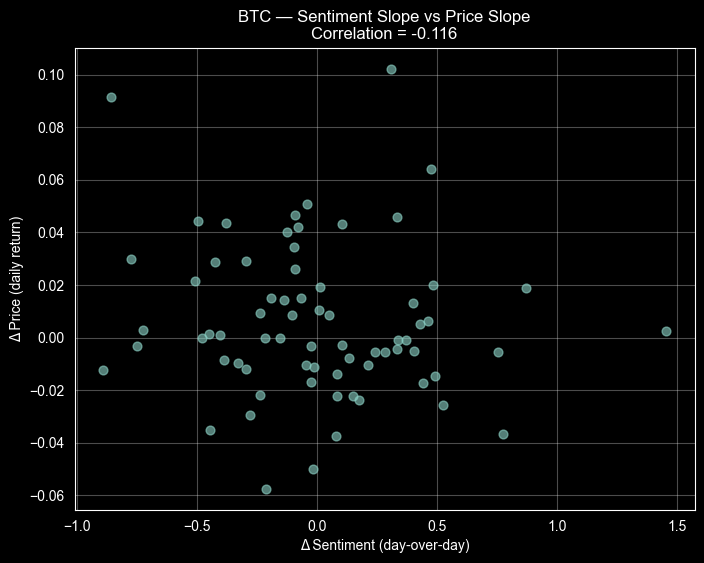

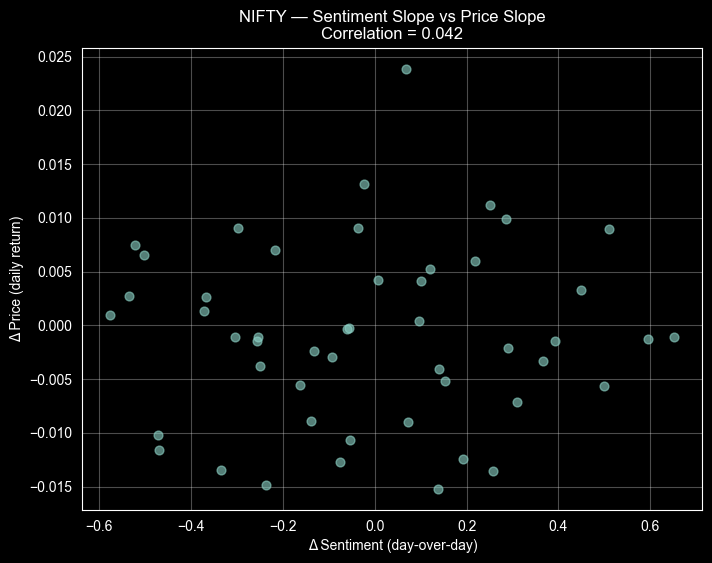

In [27]:
def plot_slope_relationship(df, asset):
    plt.figure(figsize=(8,6))

    plt.scatter(
        df["sentiment_slope"],
        df["price_slope"],
        alpha=0.6,
        s=40
    )

    corr = df["sentiment_slope"].corr(df["price_slope"])

    plt.title(
        f"{asset} — Sentiment Slope vs Price Slope\n"
        f"Correlation = {corr:.3f}"
    )
    plt.xlabel("Δ Sentiment (day-over-day)")
    plt.ylabel("Δ Price (daily return)")
    plt.grid(alpha=0.3)
    plt.show()

plot_slope_relationship(btc_slope, "BTC")
plot_slope_relationship(nifty_slope, "NIFTY")